<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [12]</a>'.</span>

<img src="../../docs/images/dlsia.png" width=600 />

# Image classification with Randomized Sparse Mixed Scale Autoencoders, regularized by the availability of image labels

**Authors:** Eric Roberts and Petrus Zwart

**E-mail:** PHZwart@lbl.gov, EJRoberts@lbl.gov

This notebook highlights some basic functionality with the dlsia package.

In this notebook we setup autoencoders, with the goal to explore the latent space it generates. In this case however, we will guide the formation of the latent space by including labels to specific images.

The autoencoders we use are based on randomly construct convolutional neural networks in which we can control the number of parameters it contains. This type of control can be beneficial when the amount of data on which one can train a network is not very voluminous, as it allows for better handles on overfitting.

The constructed latent space can be used for unsupervised and supervised exploration methods. In our limited experience, the classifiers that are trained come out of the data are reasonable, but can be improved upon using classic classification methods, as shown further.


In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from dlsia.core import helpers
from dlsia.core import train_scripts
from dlsia.core.networks import baggins
from dlsia.core.networks import sparsenet
from dlsia.test_data.two_d import random_shapes
from dlsia.core.utils import latent_space_viewer
from dlsia.viz_tools import plots
from dlsia.viz_tools import plot_autoencoder_image_classification as paic



import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import DataLoader, TensorDataset
import einops
import umap

## Create data

Using our dlsia in-house data generator, we produce a number of noisy "shapes" images consisting of single triangles, rectangles, circles, and donuts/annuli, each assigned a different class. In addition to augmenting with random orientations and sizes, each raw, ground truth image will be bundled with its corresponding noisy and binary mask.

### Parameters to toggle:
- n_train : number of ground truth/noisy/label image bundles to generate for training
- n_labeled : number of images with labels
- n_test : number of ground truth/noisy/label image bundles to generate for testing
- noise_level :  per-pixel noise drawn from a continuous uniform distribution (cut-off above at 1)
- nxy : size of individual images

In [2]:
n_train = 300
n_labeled = 200

n_test  = 400
noise_level = 0.50
nxy = 32

train_data = random_shapes.build_random_shape_set_numpy(n_imgs=n_train,
                                                        noise_level=noise_level,
                                                        n_xy=nxy)
test_data = random_shapes.build_random_shape_set_numpy(n_imgs=n_test,
                                                       noise_level=noise_level,
                                                       n_xy=nxy)


### View shapes data

In [3]:
plots.plot_shapes_data_numpy(train_data)

### Dataloader class

Here we cast all images from numpy arrays and the PyTorch Dataloader class for easy handling and iterative loading of data into the networks and models. 

Once again, to reduce/increase memory consumption, tune the batch_size parameter.

In [4]:
which_one = "Noisy" #"GroundTruth" 

batch_size = 100

loader_params = {'batch_size': batch_size, 
                 'shuffle': True} 
train_imgs = torch.Tensor(train_data[which_one]).unsqueeze(1)
train_labels = torch.Tensor(train_data["Label"]).unsqueeze(1)-1
train_labels[n_labeled:]=-1 # remove some labels to highlight 'mixed' training

Ttrain_data = TensorDataset(train_imgs,train_labels)
train_loader = DataLoader(Ttrain_data, **loader_params)

loader_params = {'batch_size': batch_size, 
                 'shuffle': False} 
test_images = torch.Tensor(test_data[which_one]).unsqueeze(1)
test_labels = torch.Tensor(test_data["Label"]).unsqueeze(1)-1
Ttest_data = TensorDataset( test_images, test_labels ) 
test_loader = DataLoader(Ttest_data, **loader_params)


## Build SMSNet Autoencoders

Define SMSNet (Sparse Mixed-Scale Network) Autoencoder architecture-governing hyperparameters here. 

### Hyperparameters to toggle

There are a number of parameters to play with that impact the size of the random sparse mixed-scale Autoencoder:

- latent_shape: the spatial footprint of the image in latent space. I don't recommend going below 4x4, because it interferes with the  dilation choices. This is a bit of a bug, we need to fix that.
- out_channels: the number of channels of the latent image. Determines the dimension of latent space: (channels,latent_shape[-2], latent_shape[-1])
- depth: the depth of the random sparse convolutional encoder / decoder
- hidden channels: The number of channels put out per convolution. 
- max_degree / min_degree : This determines how many connections you have per node.
    
    
Other parameters do not impact the size of the network dramatically / at all:

- in_shape: determined by the input shape of the image.
- dilations: the maximum dilation should not exceed the smallest image dimension.
- alpha_range: determines the type of graphs (wide vs skinny). When alpha is large,the chances for skinny graphs to be generated increases. We don't know which parameter choice is best, so we randomize it's choice.
- gamma_range: no effect unless the maximum degree and min_degree are far apart. We don't know which parameter choice is best, so we randomize it's choice.
- pIL, pLO, IO: keep as is. 
- stride_base: make sure your latent image size can be generated from the in_shape by repeated division of with this number.

For the classification, specify the number of output classes. Here we work with 4 shapes, so set it to 4.
The dropout rate governs the dropout layers in the classifier part of the networks and doesn't affect the autoencoder part.

### Initialize networks

In [5]:
autoencoders = []
n_models = 7
for ii in range(n_models):
    print('Training network ', ii)
    torch.cuda.empty_cache()
    autoencoder = sparsenet.SparseAEC(in_shape=(32, 32), 
                                      latent_shape=(8, 8), 
                                      out_classes=4,
                                      depth=40, 
                                      dilations=[1,2,3], 
                                      hidden_channels=3, 
                                      out_channels=2, 
                                      alpha_range=(0.0, 0.25), 
                                      gamma_range=(0.0, 0.5), 
                                      max_degree=10, min_degree=10, 
                                      pIL=0.15, 
                                      pLO=0.15, 
                                      IO=False, 
                                      stride_base=2, 
                                      dropout_rate=0.15,)
    autoencoders.append(autoencoder)
    pytorch_total_params = helpers.count_parameters(autoencoder)
    print( "Number of parameters in network", ii , ': ', pytorch_total_params)

Training network  0
Number of parameters in network 0 :  212762
Training network  1


Number of parameters in network 1 :  177068
Training network  2


Number of parameters in network 2 :  239150
Training network  3
Number of parameters in network 3 :  250490
Training network  4
Number of parameters in network 4 :  237485
Training network  5


Number of parameters in network 5 :  166229
Training network  6
Number of parameters in network 6 :  189650


## Train networks

We specify the learning rate and the number of epochs for used for each training instance.

**Note:** we define two optimizers: one for autoencoding and one for classification. They will be minimized in sequence (one after another) instead of building a single sum of targets. This avoids choosing the right weight. 

The mini-epochs are the number of epochs it passes over the whole data set to optimize a single target function. The autoencoder is done first.

In [6]:
num_epochs = 20
learning_rate = 1e-3
device = helpers.get_device()

for ii in range(n_models):
    autoencoder = autoencoders[ii]
    torch.cuda.empty_cache()

    criterion_AE = nn.MSELoss()
    optimizer_AE = optim.Adam(autoencoder.parameters(), lr=learning_rate)

    criterion_label = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer_label = optim.Adam(autoencoder.parameters(), lr=learning_rate)


    rv = train_scripts.autoencode_and_classify_training(net=autoencoder.to(device),
                                                        trainloader=train_loader,
                                                        validationloader=test_loader,
                                                        macro_epochs=num_epochs,
                                                        mini_epochs=3,
                                                        criteria_autoencode=criterion_AE,
                                                        minimizer_autoencode=optimizer_AE,
                                                        criteria_classify=criterion_label,
                                                        minimizer_classify=optimizer_label,
                                                        device=device, 
                                                        show=10, 
                                                        clip_value=100.0)
    
    print('Autoencoder input reconstruction performance')
    plots.plot_training_results_segmentation(rv[2]).show()
    
    print('Image classification performance')
    plots.plot_training_results_regression(rv[1]).show()


Epoch   10,  of 20 >-*-< Mini Epoch     1 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 6.2985e-02 | Validation Loss      : 6.4456e-02
Training CC      : 0.7952     | Validation CC        : 0.7809 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 5.0337e-01 | Validation Loss      : 5.7179e-01
Training F1 Macro: 0.7630     | Validation F1 Macro  : 0.7888 
Training F1 Micro: 0.7611     | Validation F1 Micro  : 0.7900 



Epoch   10,  of 20 >-*-< Mini Epoch     2 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 6.3227e-02 | Validation Loss      : 6.5241e-02
Training CC      : 0.7947     | Validation CC        : 0.7776 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.6840e-01 | Validation Loss      : 5.7115e-01
Training F1 Macro: 0.8004     | Validation F1 Macro  : 0.7582 
Training F1 Micro: 0.7978     | Validation F1 Micro  : 0.7575 



Epoch   10,  of 20 >-*-< Mini Epoch     3 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 6.4102e-02 | Validation Loss      : 6.6378e-02
Training CC      : 0.7911     | Validation CC        : 0.7727 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.2886e-01 | Validation Loss      : 5.6866e-01
Training F1 Macro: 0.8178     | Validation F1 Macro  : 0.7642 
Training F1 Micro: 0.8190     | Validation F1 Micro  : 0.7650 



Epoch   20,  of 20 >-*-< Mini Epoch     1 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.7370e-02 | Validation Loss      : 4.0131e-02
Training CC      : 0.8704     | Validation CC        : 0.8581 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.1633e-01 | Validation Loss      : 5.3341e-01
Training F1 Macro: 0.8404     | Validation F1 Macro  : 0.7514 
Training F1 Micro: 0.8367     | Validation F1 Micro  : 0.7525 



Epoch   20,  of 20 >-*-< Mini Epoch     2 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.7437e-02 | Validation Loss      : 4.0359e-02
Training CC      : 0.8702     | Validation CC        : 0.8572 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.5251e-01 | Validation Loss      : 5.4221e-01
Training F1 Macro: 0.8217     | Validation F1 Macro  : 0.7434 
Training F1 Micro: 0.8212     | Validation F1 Micro  : 0.7500 



Epoch   20,  of 20 >-*-< Mini Epoch     3 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.7579e-02 | Validation Loss      : 4.0670e-02
Training CC      : 0.8695     | Validation CC        : 0.8560 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.3844e-01 | Validation Loss      : 4.9851e-01
Training F1 Macro: 0.8192     | Validation F1 Macro  : 0.7603 
Training F1 Micro: 0.8196     | Validation F1 Micro  : 0.7650 

Autoencoder input reconstruction performance


Image classification performance


Epoch   10,  of 20 >-*-< Mini Epoch     1 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 6.0529e-02 | Validation Loss      : 6.1455e-02
Training CC      : 0.8232     | Validation CC        : 0.8134 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 5.6511e-01 | Validation Loss      : 8.0313e-01
Training F1 Macro: 0.7900     | Validation F1 Macro  : 0.6943 
Training F1 Micro: 0.7818     | Validation F1 Micro  : 0.7025 



Epoch   10,  of 20 >-*-< Mini Epoch     2 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 6.1053e-02 | Validation Loss      : 6.1804e-02
Training CC      : 0.8221     | Validation CC        : 0.8125 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 5.4874e-01 | Validation Loss      : 8.1215e-01
Training F1 Macro: 0.7531     | Validation F1 Macro  : 0.6621 
Training F1 Micro: 0.7532     | Validation F1 Micro  : 0.6675 



Epoch   10,  of 20 >-*-< Mini Epoch     3 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 6.0773e-02 | Validation Loss      : 6.2279e-02
Training CC      : 0.8229     | Validation CC        : 0.8112 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.5313e-01 | Validation Loss      : 8.1772e-01
Training F1 Macro: 0.8303     | Validation F1 Macro  : 0.6713 
Training F1 Micro: 0.8340     | Validation F1 Micro  : 0.6775 



Epoch   20,  of 20 >-*-< Mini Epoch     1 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.3329e-02 | Validation Loss      : 3.5545e-02
Training CC      : 0.8851     | Validation CC        : 0.8750 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.5151e-01 | Validation Loss      : 6.8336e-01
Training F1 Macro: 0.7785     | Validation F1 Macro  : 0.6976 
Training F1 Micro: 0.7738     | Validation F1 Micro  : 0.6975 



Epoch   20,  of 20 >-*-< Mini Epoch     2 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.4418e-02 | Validation Loss      : 3.5631e-02
Training CC      : 0.8832     | Validation CC        : 0.8746 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.5478e-01 | Validation Loss      : 6.4334e-01
Training F1 Macro: 0.7737     | Validation F1 Macro  : 0.7289 
Training F1 Micro: 0.7773     | Validation F1 Micro  : 0.7300 



Epoch   20,  of 20 >-*-< Mini Epoch     3 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.3469e-02 | Validation Loss      : 3.5728e-02
Training CC      : 0.8847     | Validation CC        : 0.8743 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.2342e-01 | Validation Loss      : 7.1145e-01
Training F1 Macro: 0.7720     | Validation F1 Macro  : 0.6831 
Training F1 Micro: 0.7721     | Validation F1 Micro  : 0.6900 

Autoencoder input reconstruction performance


Image classification performance


Epoch   10,  of 20 >-*-< Mini Epoch     1 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 4.8031e-02 | Validation Loss      : 5.0606e-02
Training CC      : 0.8302     | Validation CC        : 0.8171 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 5.7370e-01 | Validation Loss      : 8.9510e-01
Training F1 Macro: 0.8070     | Validation F1 Macro  : 0.6322 
Training F1 Micro: 0.7985     | Validation F1 Micro  : 0.6275 



Epoch   10,  of 20 >-*-< Mini Epoch     2 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 4.8313e-02 | Validation Loss      : 5.1456e-02
Training CC      : 0.8293     | Validation CC        : 0.8137 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.6558e-01 | Validation Loss      : 8.4921e-01
Training F1 Macro: 0.8164     | Validation F1 Macro  : 0.6560 
Training F1 Micro: 0.7961     | Validation F1 Micro  : 0.6425 



Epoch   10,  of 20 >-*-< Mini Epoch     3 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 4.9401e-02 | Validation Loss      : 5.2635e-02
Training CC      : 0.8251     | Validation CC        : 0.8090 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.5149e-01 | Validation Loss      : 8.7957e-01
Training F1 Macro: 0.8098     | Validation F1 Macro  : 0.6483 
Training F1 Micro: 0.8046     | Validation F1 Micro  : 0.6375 



Epoch   20,  of 20 >-*-< Mini Epoch     1 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.3902e-02 | Validation Loss      : 3.7567e-02
Training CC      : 0.8830     | Validation CC        : 0.8671 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.4280e-01 | Validation Loss      : 7.6109e-01
Training F1 Macro: 0.7706     | Validation F1 Macro  : 0.6531 
Training F1 Micro: 0.7596     | Validation F1 Micro  : 0.6425 



Epoch   20,  of 20 >-*-< Mini Epoch     2 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.4041e-02 | Validation Loss      : 3.7667e-02
Training CC      : 0.8828     | Validation CC        : 0.8667 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.5633e-01 | Validation Loss      : 7.5780e-01
Training F1 Macro: 0.7762     | Validation F1 Macro  : 0.6592 
Training F1 Micro: 0.7605     | Validation F1 Micro  : 0.6500 



Epoch   20,  of 20 >-*-< Mini Epoch     3 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.3995e-02 | Validation Loss      : 3.7810e-02
Training CC      : 0.8828     | Validation CC        : 0.8662 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.9895e-01 | Validation Loss      : 8.0559e-01
Training F1 Macro: 0.8204     | Validation F1 Macro  : 0.6360 
Training F1 Micro: 0.8156     | Validation F1 Micro  : 0.6325 

Autoencoder input reconstruction performance


Image classification performance


Epoch   10,  of 20 >-*-< Mini Epoch     1 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 7.9677e-02 | Validation Loss      : 8.0933e-02
Training CC      : 0.7870     | Validation CC        : 0.7753 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.6338e-01 | Validation Loss      : 7.6495e-01
Training F1 Macro: 0.7961     | Validation F1 Macro  : 0.6881 
Training F1 Micro: 0.7855     | Validation F1 Micro  : 0.6900 



Epoch   10,  of 20 >-*-< Mini Epoch     2 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 7.9560e-02 | Validation Loss      : 8.1246e-02
Training CC      : 0.7879     | Validation CC        : 0.7750 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.6199e-01 | Validation Loss      : 7.5115e-01
Training F1 Macro: 0.8244     | Validation F1 Macro  : 0.7013 
Training F1 Micro: 0.8198     | Validation F1 Micro  : 0.7000 



Epoch   10,  of 20 >-*-< Mini Epoch     3 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 7.9998e-02 | Validation Loss      : 8.1631e-02
Training CC      : 0.7875     | Validation CC        : 0.7743 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.7254e-01 | Validation Loss      : 7.2606e-01
Training F1 Macro: 0.7911     | Validation F1 Macro  : 0.6903 
Training F1 Micro: 0.7900     | Validation F1 Micro  : 0.6950 



Epoch   20,  of 20 >-*-< Mini Epoch     1 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 4.0111e-02 | Validation Loss      : 4.3358e-02
Training CC      : 0.8606     | Validation CC        : 0.8457 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.0120e-01 | Validation Loss      : 7.0179e-01
Training F1 Macro: 0.8189     | Validation F1 Macro  : 0.7208 
Training F1 Micro: 0.8094     | Validation F1 Micro  : 0.7125 



Epoch   20,  of 20 >-*-< Mini Epoch     2 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.9805e-02 | Validation Loss      : 4.3431e-02
Training CC      : 0.8613     | Validation CC        : 0.8454 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.3020e-01 | Validation Loss      : 7.0873e-01
Training F1 Macro: 0.8045     | Validation F1 Macro  : 0.7041 
Training F1 Micro: 0.8002     | Validation F1 Micro  : 0.7000 



Epoch   20,  of 20 >-*-< Mini Epoch     3 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 4.0328e-02 | Validation Loss      : 4.3523e-02
Training CC      : 0.8602     | Validation CC        : 0.8451 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.6362e-01 | Validation Loss      : 7.0729e-01
Training F1 Macro: 0.8048     | Validation F1 Macro  : 0.7036 
Training F1 Micro: 0.7993     | Validation F1 Micro  : 0.6975 

Autoencoder input reconstruction performance


Image classification performance


Epoch   10,  of 20 >-*-< Mini Epoch     1 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 5.7922e-02 | Validation Loss      : 5.8190e-02
Training CC      : 0.8230     | Validation CC        : 0.8152 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.6086e-01 | Validation Loss      : 5.9078e-01
Training F1 Macro: 0.8195     | Validation F1 Macro  : 0.7820 
Training F1 Micro: 0.8131     | Validation F1 Micro  : 0.7725 



Epoch   10,  of 20 >-*-< Mini Epoch     2 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 5.8262e-02 | Validation Loss      : 5.8749e-02
Training CC      : 0.8218     | Validation CC        : 0.8128 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.5196e-01 | Validation Loss      : 5.8274e-01
Training F1 Macro: 0.8285     | Validation F1 Macro  : 0.7739 
Training F1 Micro: 0.8128     | Validation F1 Micro  : 0.7700 



Epoch   10,  of 20 >-*-< Mini Epoch     3 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 5.8892e-02 | Validation Loss      : 5.9587e-02
Training CC      : 0.8192     | Validation CC        : 0.8093 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.8878e-01 | Validation Loss      : 5.3349e-01
Training F1 Macro: 0.7639     | Validation F1 Macro  : 0.7944 
Training F1 Micro: 0.7556     | Validation F1 Micro  : 0.7900 



Epoch   20,  of 20 >-*-< Mini Epoch     1 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.2747e-02 | Validation Loss      : 3.4413e-02
Training CC      : 0.8874     | Validation CC        : 0.8789 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.6131e-01 | Validation Loss      : 5.2778e-01
Training F1 Macro: 0.8485     | Validation F1 Macro  : 0.7890 
Training F1 Micro: 0.8502     | Validation F1 Micro  : 0.7850 



Epoch   20,  of 20 >-*-< Mini Epoch     2 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.3116e-02 | Validation Loss      : 3.4546e-02
Training CC      : 0.8865     | Validation CC        : 0.8784 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.1906e-01 | Validation Loss      : 5.5054e-01
Training F1 Macro: 0.7689     | Validation F1 Macro  : 0.7191 
Training F1 Micro: 0.7655     | Validation F1 Micro  : 0.7175 



Epoch   20,  of 20 >-*-< Mini Epoch     3 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.2976e-02 | Validation Loss      : 3.4725e-02
Training CC      : 0.8866     | Validation CC        : 0.8777 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.9865e-01 | Validation Loss      : 4.9507e-01
Training F1 Macro: 0.7833     | Validation F1 Macro  : 0.7869 
Training F1 Micro: 0.7790     | Validation F1 Micro  : 0.7825 

Autoencoder input reconstruction performance


Image classification performance


Epoch   10,  of 20 >-*-< Mini Epoch     1 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 6.4412e-02 | Validation Loss      : 6.4328e-02
Training CC      : 0.8157     | Validation CC        : 0.8083 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 5.2399e-01 | Validation Loss      : 7.4046e-01
Training F1 Macro: 0.8103     | Validation F1 Macro  : 0.6754 
Training F1 Micro: 0.8096     | Validation F1 Micro  : 0.6800 



Epoch   10,  of 20 >-*-< Mini Epoch     2 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 6.4511e-02 | Validation Loss      : 6.4819e-02
Training CC      : 0.8155     | Validation CC        : 0.8065 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 5.6345e-01 | Validation Loss      : 6.7119e-01
Training F1 Macro: 0.7994     | Validation F1 Macro  : 0.7209 
Training F1 Micro: 0.8006     | Validation F1 Micro  : 0.7200 



Epoch   10,  of 20 >-*-< Mini Epoch     3 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 6.5428e-02 | Validation Loss      : 6.5912e-02
Training CC      : 0.8124     | Validation CC        : 0.8026 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.9491e-01 | Validation Loss      : 6.9220e-01
Training F1 Macro: 0.7955     | Validation F1 Macro  : 0.7068 
Training F1 Micro: 0.7903     | Validation F1 Micro  : 0.7100 



Epoch   20,  of 20 >-*-< Mini Epoch     1 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.3383e-02 | Validation Loss      : 3.4724e-02
Training CC      : 0.8850     | Validation CC        : 0.8778 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.9039e-01 | Validation Loss      : 5.6450e-01
Training F1 Macro: 0.8055     | Validation F1 Macro  : 0.7277 
Training F1 Micro: 0.8117     | Validation F1 Micro  : 0.7300 



Epoch   20,  of 20 >-*-< Mini Epoch     2 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.3443e-02 | Validation Loss      : 3.4870e-02
Training CC      : 0.8848     | Validation CC        : 0.8772 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.3819e-01 | Validation Loss      : 6.0607e-01
Training F1 Macro: 0.7679     | Validation F1 Macro  : 0.7156 
Training F1 Micro: 0.7655     | Validation F1 Micro  : 0.7125 



Epoch   20,  of 20 >-*-< Mini Epoch     3 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.3730e-02 | Validation Loss      : 3.5133e-02
Training CC      : 0.8839     | Validation CC        : 0.8761 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.5245e-01 | Validation Loss      : 5.1650e-01
Training F1 Macro: 0.7606     | Validation F1 Macro  : 0.7583 
Training F1 Micro: 0.7597     | Validation F1 Micro  : 0.7575 

Autoencoder input reconstruction performance


Image classification performance


Epoch   10,  of 20 >-*-< Mini Epoch     1 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 8.7272e-02 | Validation Loss      : 8.8319e-02
Training CC      : 0.7837     | Validation CC        : 0.7730 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.8312e-01 | Validation Loss      : 7.9571e-01
Training F1 Macro: 0.8094     | Validation F1 Macro  : 0.6441 
Training F1 Micro: 0.8109     | Validation F1 Micro  : 0.6500 



Epoch   10,  of 20 >-*-< Mini Epoch     2 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 8.7553e-02 | Validation Loss      : 8.8673e-02
Training CC      : 0.7829     | Validation CC        : 0.7718 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.2894e-01 | Validation Loss      : 7.6937e-01
Training F1 Macro: 0.8377     | Validation F1 Macro  : 0.6728 
Training F1 Micro: 0.8335     | Validation F1 Micro  : 0.6725 



Epoch   10,  of 20 >-*-< Mini Epoch     3 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 8.7755e-02 | Validation Loss      : 8.9131e-02
Training CC      : 0.7819     | Validation CC        : 0.7701 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.2296e-01 | Validation Loss      : 7.4708e-01
Training F1 Macro: 0.8250     | Validation F1 Macro  : 0.6730 
Training F1 Micro: 0.8200     | Validation F1 Micro  : 0.6725 



Epoch   20,  of 20 >-*-< Mini Epoch     1 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.2969e-02 | Validation Loss      : 3.5872e-02
Training CC      : 0.8864     | Validation CC        : 0.8737 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.0471e-01 | Validation Loss      : 7.5713e-01
Training F1 Macro: 0.8261     | Validation F1 Macro  : 0.6565 
Training F1 Micro: 0.8243     | Validation F1 Micro  : 0.6650 



Epoch   20,  of 20 >-*-< Mini Epoch     2 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.3562e-02 | Validation Loss      : 3.5964e-02
Training CC      : 0.8855     | Validation CC        : 0.8734 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.8256e-01 | Validation Loss      : 7.2090e-01
Training F1 Macro: 0.7290     | Validation F1 Macro  : 0.6599 
Training F1 Micro: 0.7394     | Validation F1 Micro  : 0.6675 



Epoch   20,  of 20 >-*-< Mini Epoch     3 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.3207e-02 | Validation Loss      : 3.6072e-02
Training CC      : 0.8859     | Validation CC        : 0.8729 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.0074e-01 | Validation Loss      : 7.3339e-01
Training F1 Macro: 0.8572     | Validation F1 Macro  : 0.6659 
Training F1 Micro: 0.8548     | Validation F1 Micro  : 0.6700 

Autoencoder input reconstruction performance


Image classification performance


## Network evaluation

We pass over the test data again with the newly trained networks and collect stuff so we can inspect what is happening.

### Network bagging

In [7]:
bagged_model = baggins.autoencoder_labeling_model_baggin(autoencoders)

In [8]:
print(bagged_model)

autoencoder_labeling_model_baggin()


In [9]:
import tqdm
results = []
pres = []
sresults = []
spres = []

latent = []
true_lbl = []
inp_img = []
for batch in tqdm.tqdm(test_loader):
    true_lbl.append(batch[1])
    with torch.no_grad():
        inp_img.append(batch[0].cpu())
        res, sres, ps, sps = bagged_model(batch[0], device, True)        
        results.append(res.cpu())
        pres.append(ps.cpu())
        sresults.append(sres.cpu())
        spres.append(sps.cpu())
        
results = torch.cat(results, dim=0)
pres = torch.cat(pres,dim=0)
sresults = torch.cat(sresults, dim=0)
spres = torch.cat(spres,dim=0)

true_lbl = torch.cat(true_lbl, dim=0)    
inp_img = torch.cat(inp_img, dim=0)

  0%|                                                                       | 0/4 [00:00<?, ?it/s]

 25%|███████████████▊                                               | 1/4 [00:01<00:03,  1.03s/it]

 50%|███████████████████████████████▌                               | 2/4 [00:02<00:02,  1.16s/it]

 75%|███████████████████████████████████████████████▎               | 3/4 [00:03<00:01,  1.20s/it]

100%|███████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.22s/it]

100%|███████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.20s/it]

### Network performance metrics

We evaluate the bagged calssifier performance using  F1 scores.

In [10]:
Macro_F1, Micro_F1 = train_scripts.segmentation_metrics(pres, true_lbl[:,0].type(torch.LongTensor))
print(f"Macro F1 on Test Data {Macro_F1: 6.5f}")
print(f"Micro F1 on Test Data {Micro_F1: 6.5f}")


Macro F1 on Test Data  0.96500
Micro F1 on Test Data  0.96424


### View predictions and confidence

Below we view the network predictions on images previously unseen in the training process. Class probabilities and prediction confidence is shown

--------       The first 10 images encountered     ----------


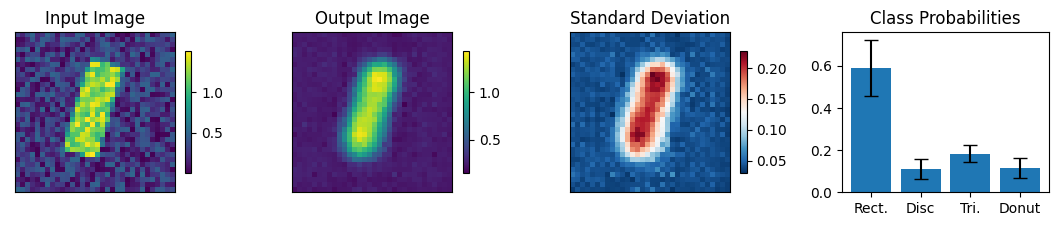

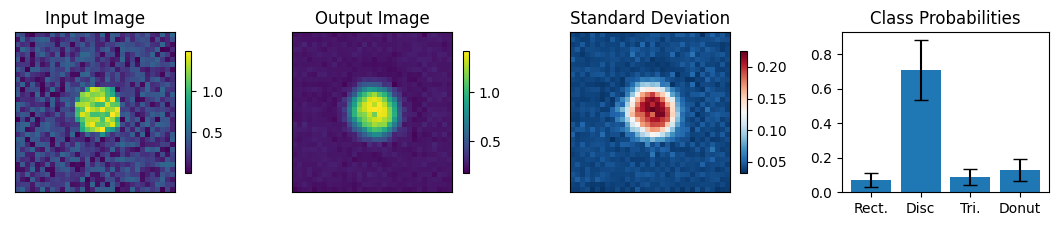

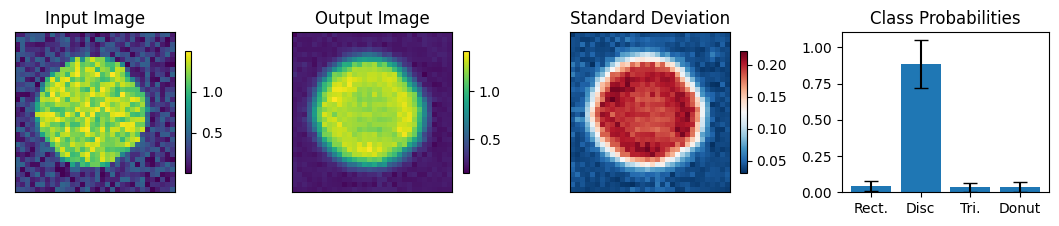

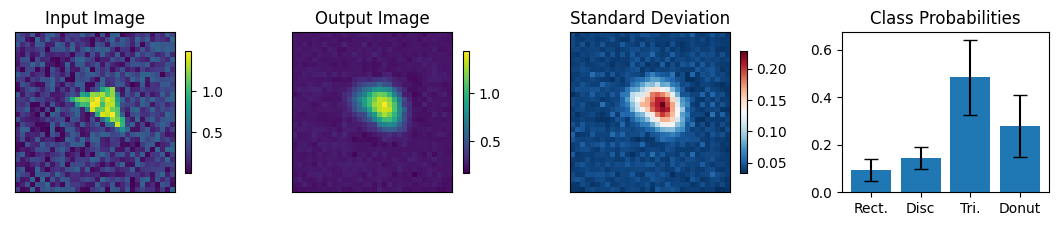

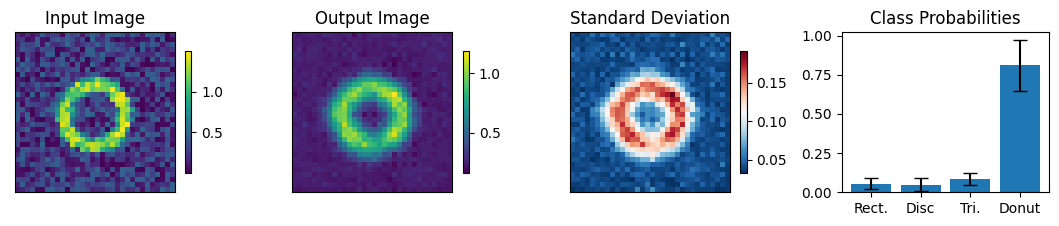

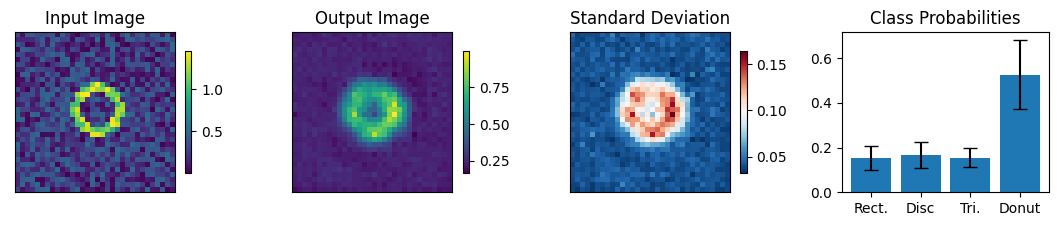

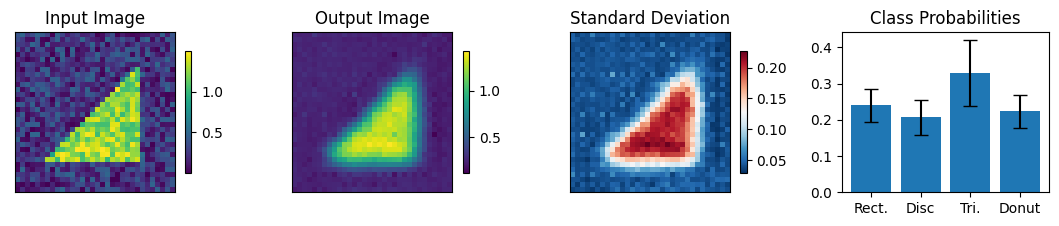

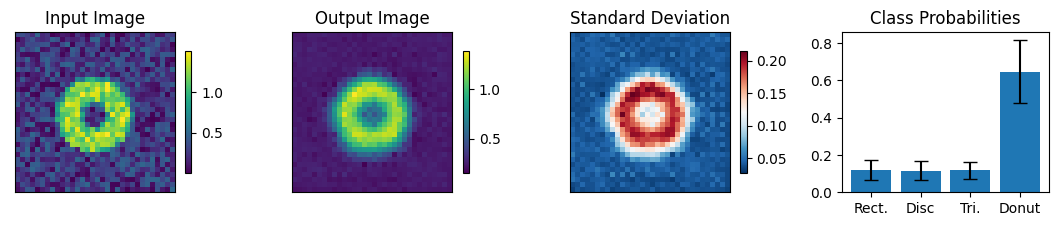

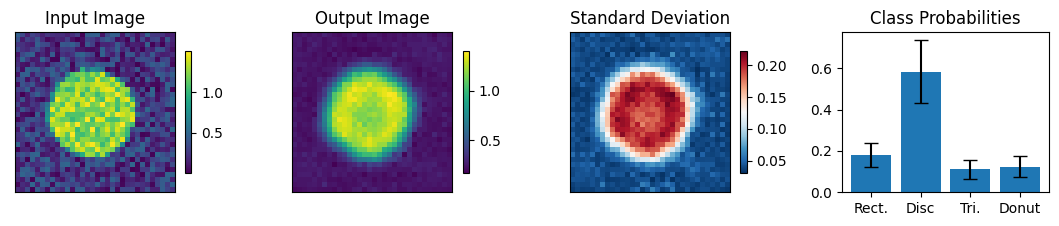

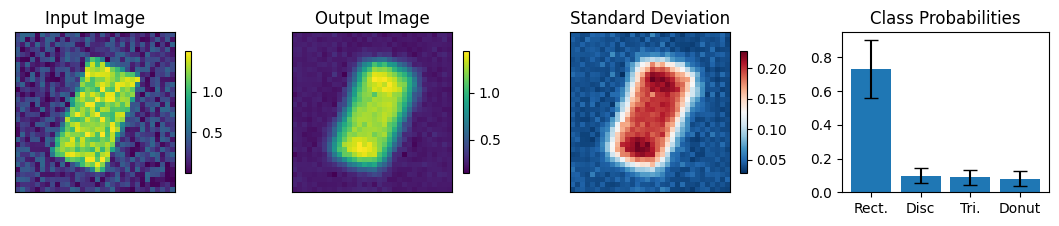

--------       Incorrectly labeled images  (10 max)   ----------


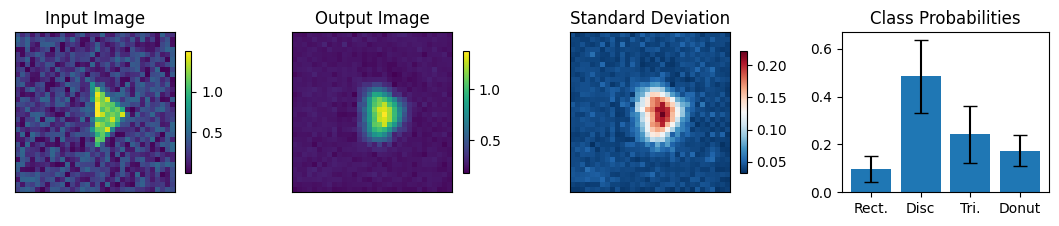

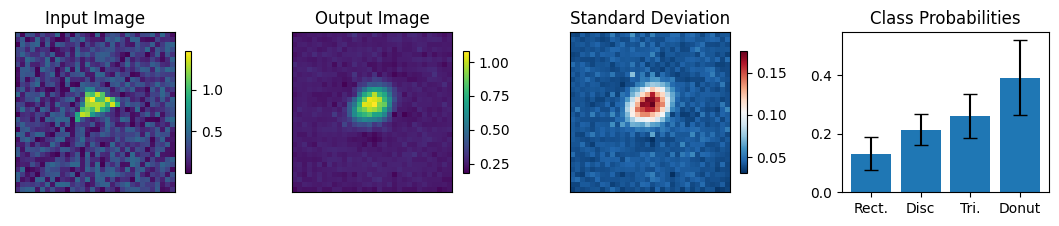

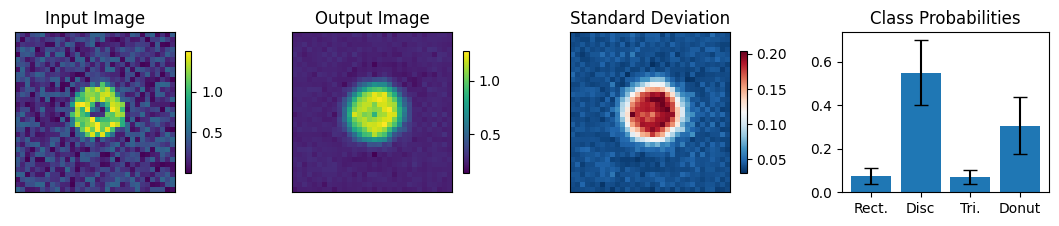

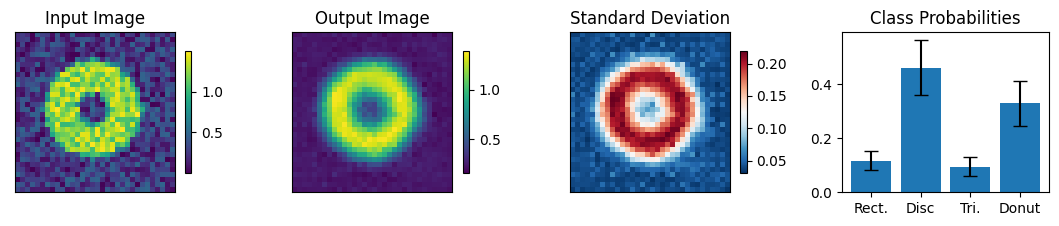

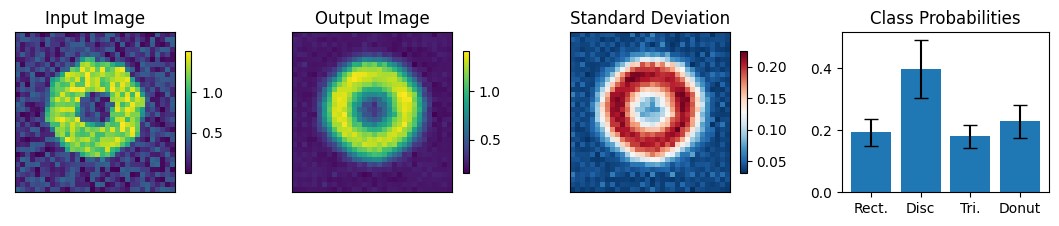

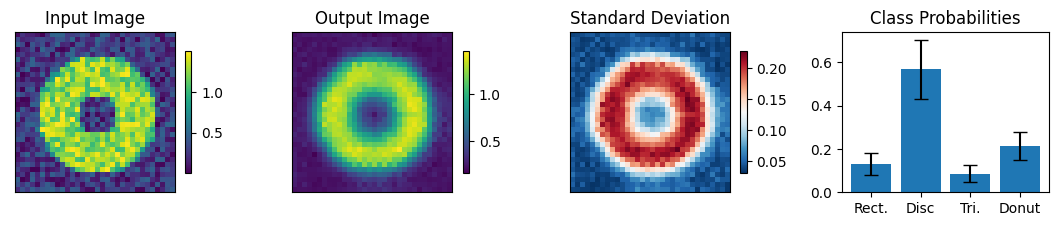

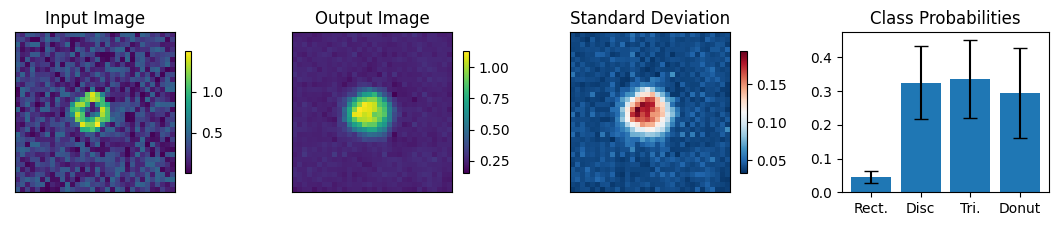

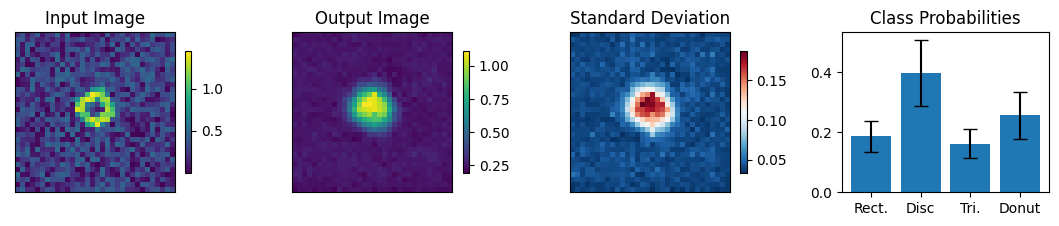

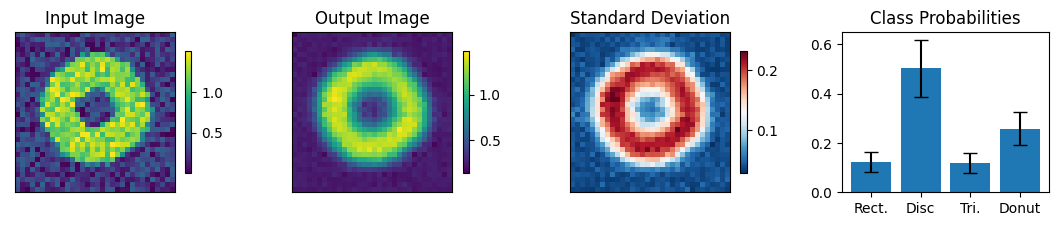

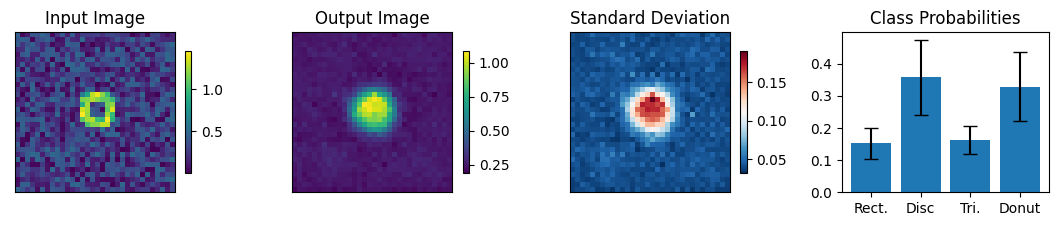

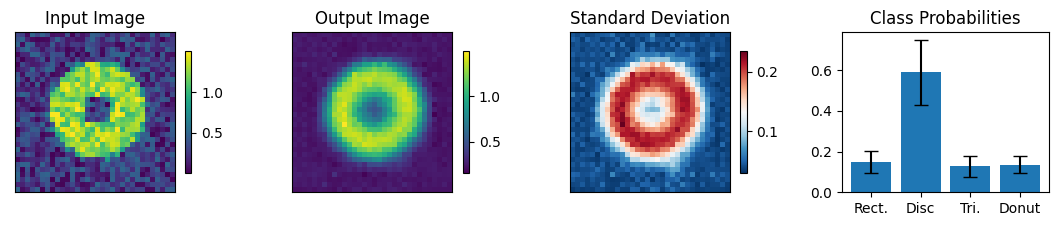

In [11]:
count = 0
print("--------       The first 10 images encountered     ----------")
for img, simg, p, sp, tlbl, ori in zip(results, sresults, pres, spres, true_lbl, inp_img):
    if count < 10:
        fig = paic.plot_autoencoder_and_label_results_with_std(
            input_img=ori[0].numpy(),
            output_img=img[0].numpy(),
            std_img=simg[0].numpy(),
            p_classification=p.numpy(),
            std_p_classification=sp.numpy(),
            class_names=["Rect.","Disc","Tri.","Donut"])
        plt.show()
        count += 1
    

print("--------       Incorrectly labeled images  (10 max)   ----------")
count = 0
for img, simg, p, sp, tlbl, ori in zip(results, sresults, pres, spres, true_lbl, inp_img):
    ilbl = np.argmax(p.numpy())
    if int(tlbl) != int(ilbl):
        fig = paic.plot_autoencoder_and_label_results_with_std(
            input_img=ori[0].numpy(),
            output_img=img[0].numpy(),
            std_img=simg[0].numpy(),
            p_classification=p.numpy(),
            std_p_classification=sp.numpy(),
            class_names=["Rect.","Disc","Tri.","Donut"])
        plt.show()
        count += 1
    if count > 10:
        break


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [12]:
latent = einops.rearrange(latent, "N C Y X -> N (C Y X)")
umapper = umap.UMAP(min_dist=0, n_neighbors=35)
X = umapper.fit_transform(latent.numpy())

TypeError: Rearrange can't be applied to an empty list

In [ ]:
count = 0
for img, cc, tlbl, ori, pl in zip(results, pres, true_lbl, inp_img, infered_labels):
    if int(tlbl[0]) != pl-1:        
        paic.plot_autoencoder_and_label_results(input_img=ori.numpy()[0,...], 
                                       output_img=img.numpy()[0,...], 
                                       p_classification=cc.numpy(),
                                       class_names=["Rectangle","Disc","Triangle","Annulus"])
        plt.show()
        count += 1
    if count > 5:
        break